In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.contrib.layers as layers
import matplotlib.pyplot as plt
from sklearn import *
import math 
import random
import itertools
from sklearn.feature_selection import mutual_info_regression


In [2]:
# data
d=10
L=2000
e=2.71828


def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1.0 / tf.sqrt(in_dim / 2.0)
    return tf.random_normal(shape=size, stddev=xavier_stddev)



def log2(x):
    numerator = tf.log(x)
    denominator = tf.log(tf.constant(2, dtype=numerator.dtype),)
    return numerator / denominator

def func(x):
    return x


def gen_X():
    return np.random.multivariate_normal( mean=meu,
                                  cov=eta_X,
                                  size = L)


def gen_Y(X):
    return func(X)+ np.random.multivariate_normal( mean=meu, cov=eta_N, size = L)



In [3]:
def ma(array, policy,window_size=None, beta=None):
    x=np.zeros(len(array))
    if policy=='window':
        for i in range(0, len(array)):
            if i<window_size:
                x[i]= np.mean(array[0: i])
            else:
                x[i]= np.mean(array[i-window_size: i])
    elif policy=='weighted':
        x[0]=array[0]
        for i in range(1, len(array)):
               x[i]=x[i-1]*(1-beta)+beta*array[i]
    elif policy=='None':
        for i in range(1, len(array)):
             x[i]=array[i] 
    return x


In [4]:
def MINE(x, y):


    L1=20
    L2=10
    L3=5
    L4=5
    L5=5

    x_shuffle=tf.random_shuffle(x)
    y_shuffle=tf.random_shuffle(y)
    In = tf.concat([x, y], axis=1)
    In_shuffle = tf.concat([x, y_shuffle], axis=1)

   # x=tf.reshape(x,[-1,1])
  #  y=tf.reshape(y,[-1,1])
   # x_shuffle=tf.reshape(x_shuffle,[-1,1])
   # y_shuffle=tf.reshape(y_shuffle,[-1,1])


    W1=tf.Variable(xavier_init([2*d, L1]))
    b1=tf.Variable(tf.zeros([L1]))

    layer_joint1=tf.nn.relu(tf.matmul(In,W1)+b1)
    layer_marg1=tf.nn.relu(tf.matmul(In_shuffle,W1)+b1)
    
    Wh2=tf.Variable(xavier_init( [L1,L2]))
    bh2=tf.Variable(tf.zeros([L2]))

    layer_joint2=tf.nn.relu(tf.matmul(layer_joint1,Wh2)+bh2)
    layer_marg2=tf.nn.relu(tf.matmul(layer_marg1,Wh2)+bh2)


    Wh3=tf.Variable(xavier_init( [L2,L3]))
    bh3=tf.Variable(tf.zeros([L3]))

    layer_joint3=tf.nn.relu(tf.matmul(layer_joint2,Wh3)+bh3)
    layer_marg3=tf.nn.relu(tf.matmul(layer_marg2,Wh3)+bh3)

    Wh4=tf.Variable(xavier_init( [L3,L4]))
    bh4=tf.Variable(tf.zeros([L4]))

    layer_joint4=tf.nn.relu(tf.matmul(layer_joint3,Wh4)+bh4)
    layer_marg4=tf.nn.relu(tf.matmul(layer_marg3,Wh4)+bh4)
    
    Wh5=tf.Variable(xavier_init( [L4,L5]))
    bh5=tf.Variable(tf.zeros([L5]))

    layer_joint5=tf.nn.relu(tf.matmul(layer_joint4,Wh5)+bh5)
    layer_marg5=tf.nn.relu(tf.matmul(layer_marg4,Wh5)+bh5)
    
    Wout=tf.Variable(xavier_init( [L5,1]))
    bout=tf.Variable(tf.zeros([1]))

    out_joint=tf.matmul(layer_joint3,Wout)+bout
    out_marg=tf.matmul(layer_marg3,Wout)+bout

    lower_bound=(tf.reduce_mean(out_joint,axis=0)-log2(tf.reduce_mean(tf.math.pow(2.0,out_marg),axis=0)+10e-5))

    theta = [W1,b1,Wh2, bh2,Wh3,bh3, Wh4,bh4 ,Wh5,bh5 ,Wout, bout]

    opt = tf.train.AdamOptimizer(0.01).minimize((-lower_bound), var_list=[theta])


    return lower_bound, opt

In [5]:
#alternative achitecture

L1=20
L2=10
L3=5
L4=5
L5=5
n_epochs = 2000
data_size = 20000
def MINE_alt(x_in, y_in):
    
    # shuffle and concatenate
    y_shuffle = tf.random_shuffle(y_in)
    x_conc = tf.concat([x_in, x_in], axis=0)
    y_conc = tf.concat([y_in, y_shuffle], axis=0)
    In=tf.concat([x_conc,y_conc], axis=1)
    # propagate the forward pass

    layer1 = tf.contrib.layers.fully_connected(In, L1,weights_initializer=layers.xavier_initializer(), activation_fn=tf.nn.tanh)
    layer2 = tf.contrib.layers.fully_connected(layer1, L2,weights_initializer=layers.xavier_initializer(), activation_fn=tf.nn.tanh)
    layer3 = tf.contrib.layers.fully_connected(layer2, L3,weights_initializer=layers.xavier_initializer(), activation_fn=tf.nn.tanh)
    layer4 = tf.contrib.layers.fully_connected(layer3, L4,weights_initializer=layers.xavier_initializer(), activation_fn=tf.nn.tanh)
    layer5 = tf.contrib.layers.fully_connected(layer4, L5,weights_initializer=layers.xavier_initializer(), activation_fn=tf.nn.tanh)
    output = tf.contrib.layers.fully_connected(layer5, 1,weights_initializer=layers.xavier_initializer(), activation_fn=None)

    
    # split in T_xy and T_x_y predictions
    N_samples = L
    T_xy = output[:N_samples]
    T_x_y = output[N_samples:]
    # compute the negative loss (maximise loss == minimise -loss)
    lower_bound = (tf.reduce_mean(T_xy, axis=0) - log2(tf.reduce_mean(tf.math.pow(2.0,T_x_y)))+10e-5)
    opt = tf.train.AdamOptimizer(learning_rate=0.01).minimize(-neg_loss)
    
    return lower_bound, opt

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
true value:00000166
6.870890261326204
calculated value:
5.862264156341553
error
-14.67970039722289




C:\Users\ahmedadel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:54: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


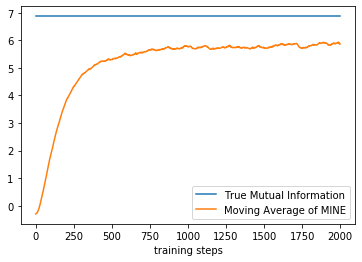

In [6]:
# prepare the placeholders for inputs
x_in = tf.placeholder(tf.float32, [None, d], name='x_in')
y_in = tf.placeholder(tf.float32, [None, d], name='y_in')
# make the loss and optimisation graphs
lower_bound, train_step= MINE(x_in, y_in)

# start the session
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

# train
MIs = []

n_epochs = 2000
meu=np.zeros(d)
eta_X=datasets.make_spd_matrix(d, random_state=None)
eta_N=datasets.make_spd_matrix(d, random_state=None)   
eta_Y=eta_X+eta_N


x=gen_X()
y=gen_Y(x)
mi = 0.5*np.log2(np.linalg.det(eta_Y)/np.linalg.det(eta_N))



for epoch in range(n_epochs):

    # generate the data
    x_sample=gen_X()
    y_sample=gen_Y(x_sample)


    # perform the training step 
    feed_dict = {x_in:x_sample, y_in:y_sample}
    low_bnd,_ = sess.run([lower_bound, train_step], feed_dict=feed_dict)
   # print (te)
    # save the loss
    MIs.append(low_bnd)
    print(epoch/n_epochs*100,end='\r')



mv_av=ma(MIs, policy='weighted', beta=0.01)

fig, ax = plt.subplots()
ax.plot([0, len(MIs)], [mi,mi], label='True Mutual Information')
ax.plot(range(len(mv_av)), mv_av, label='Moving Average of MINE')

ax.set_xlabel('training steps')

ax.legend(loc='best')
fig.savefig('MINE_10D_10.png')
fig.show()



error=((mv_av[-1]-mi)/mi)*100


print('true value:')
print(mi)
print('calculated value:')
print(mv_av[-1])
print('error')
print(error)
print('\n')


op = open("d=10.txt","a") 

op.write( 'True value: {:.4} ; calculated value: {:.4}; error: {:.4}% \n'
    .format(mi, mv_av[-1], error)) 
op.close() 

